## INFO 634 Project Abstract
### Market basket analysis and recommendation of Instacart

#### Team members:
Anandhi Solaimuthu (as5326@drexel.edu)\
Anju Tyagi (at3358@drexel.edu)\
Manasa J (mj658@drexel.edu)\
Harshita Guddad (hg449@drexel.edu)

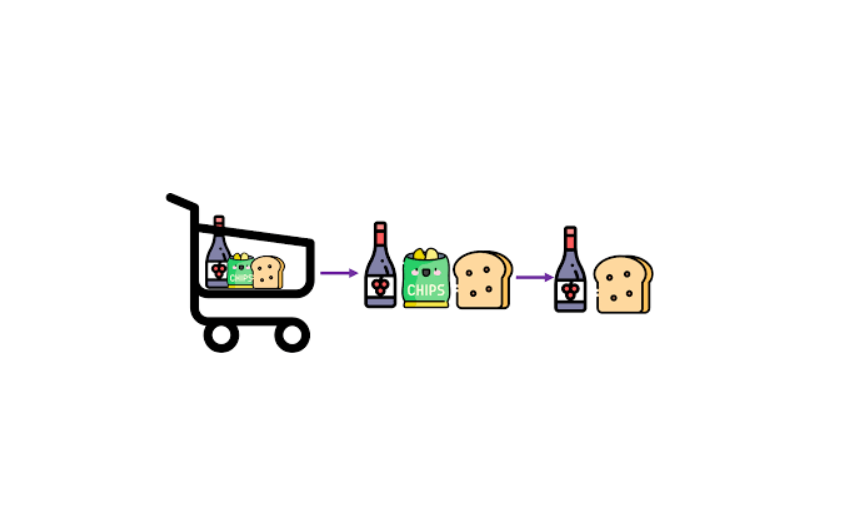

In [1]:
from IPython.display import Image
Image('./Data/MBA_image.png')

### Objective:
Analyzing and finding the co-relation of attributes in dataset and suggesting the users some items that he/she may buy again or along with a current order . In other words, the objective is to develop Market Basket Analysis model which helps in identifying the next product that might interest a customer.

### Problem statement and Motivation:
In the current situation like global pandemic, offline shopping will be challenging and risky, due to which e-commerce sites like Instacart provides door delivery services that ease shopping experience for customers.

While we are working on recommendation, this has many benefits - this will help vendors increase their sales by recommending likely products to customers. At the same time, sales teams can develop more effective pricing, product placement, cross-sell and up-sell strategies.

### Data source:
The data is collected from https://www.instacart.com/datasets/grocery-shopping-2017. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The dataset is a relational set of files describing customers' orders over time.


__orders:__

order_id: order identifier

user_id: customer identifier

eval_set: which evaluation set this order belongs in (see SET described below)

order_number: the order sequence number for this user (1 = first, n = nth)

order_dow: the day of the week the order was placed on

order_hour_of_day: the hour of the day the order was placed on

days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

__products:__

product_id: product identifier

product_name: name of the product

aisle_id: foreign key

department_id: foreign key

__deptartments :__

department_id: department identifier

department: the name of the department

__order_products_prior :__

order_id: foreign key

product_id: foreign key

add_to_cart_order: order in which each product was added to cart

reordered: 1 if this product has been ordered by this user in the past, 0 otherwise



#### Loading libraries and data:

In [2]:
# Importing required libraries.
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None
import random
import matplotlib.colors as mcolors
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# !pip install wordcloud
from wordcloud import WordCloud

In [3]:
#reading the data files
order_products_df = pd.read_csv("./Data/order_products__prior.csv")
orders_df = pd.read_csv("./Data/orders.csv")
products_df = pd.read_csv("./Data/products.csv")
departments_df = pd.read_csv("./Data/departments.csv")

In [4]:
order_products_df.shape

(32434489, 4)

As the data is huge with 3 million orders so, we will be working on 50K orders so that it won’t be computationally expensive.

In [5]:
orders = order_products_df[order_products_df['order_id'].between(0, 50000)]

In [6]:
print(orders.shape)
print()
print(orders.info())

(472850, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472850 entries, 0 to 472849
Data columns (total 4 columns):
order_id             472850 non-null int64
product_id           472850 non-null int64
add_to_cart_order    472850 non-null int64
reordered            472850 non-null int64
dtypes: int64(4)
memory usage: 18.0 MB
None


#### Data Integration

In [7]:
#Merging 4 dataset into one
orders = pd.merge(orders, products_df, on='product_id', how='left')
orders = pd.merge(orders, orders_df, on='order_id', how='left')
orders = pd.merge(orders, departments_df, on='department_id', how='left')
# To display the top 5 rows
orders.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,pantry


In [8]:
# To display the bottom 5 rows
orders.tail(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
472845,49999,13802,13,1,Salted Sweet Cream Butter,36,16,70014,prior,71,3,19,5.0,dairy eggs
472846,50000,26452,1,0,Dairy Free Gluten Free Cheeze Lover's Pizza,42,1,130746,prior,3,4,9,2.0,frozen
472847,50000,10492,2,0,Coconut Milk,66,6,130746,prior,3,4,9,2.0,international
472848,50000,37355,3,0,Organic Extra Virgin Coconut Oil,19,13,130746,prior,3,4,9,2.0,pantry
472849,50000,32254,4,1,Mixed Berry Low Fat Almond Non-Dairy Yogurt,120,16,130746,prior,3,4,9,2.0,dairy eggs


In [9]:
# Checking the data type
orders.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
department                 object
dtype: object

In [10]:
#Detailed description of each numeric column
orders.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,472850.000000,442562.000000
mean,24963.280000,25563.428203,8.345812,0.590022,71.210134,9.924642,103229.546192,17.260326,2.737853,13.435307,10.996536
std,14431.240909,14098.168623,7.113995,0.491830,38.198375,6.283266,59409.029756,17.740971,2.083898,4.261256,8.674995
min,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000
25%,12494.000000,13517.000000,3.000000,0.000000,31.000000,4.000000,51649.000000,5.000000,1.000000,10.000000,5.000000
50%,24927.000000,25244.000000,6.000000,1.000000,83.000000,9.000000,103005.000000,11.000000,3.000000,13.000000,8.000000
75%,37443.000000,37840.000000,11.000000,1.000000,107.000000,16.000000,155147.000000,24.000000,5.000000,16.000000,15.000000
max,50000.000000,49688.000000,92.000000,1.000000,134.000000,21.000000,206208.000000,99.000000,6.000000,23.000000,30.000000


In [11]:
#Detailed description of each categorical column
orders[["product_name","department"]].describe()

,product_name,department
count,472850,472850
unique,28701,21
top,Banana,produce
freq,6966,137575


#### Data Cleaning

In [12]:
# missing entry check
orders.isna().sum()

order_id                      0
product_id                    0
add_to_cart_order             0
reordered                     0
product_name                  0
aisle_id                      0
department_id                 0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    30288
department                    0
dtype: int64

Here our data has an information of previous orders from customers and if there is any reorder, the days_since_prior_order will be incremented accordingly and N/A if there is no reorder. Since we are mainly working on association rule and we are not making use of this feature, this column will be dropped.


In [13]:
orders=orders.drop(columns=["days_since_prior_order"])

In [14]:
# removing irrelavent columns
orders=orders.drop(columns=["reordered","aisle_id","eval_set","order_number"])

#### Data Visualization:

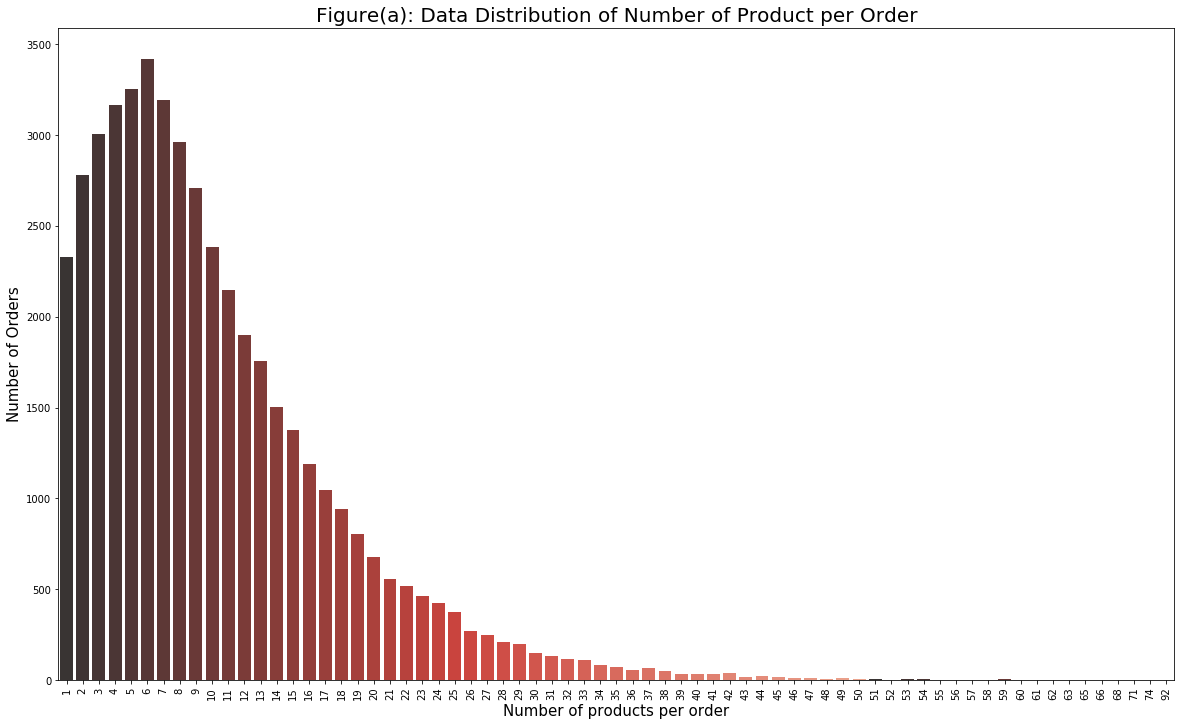

In [15]:
# data distribution plot
group = orders.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
group = group.add_to_cart_order.value_counts()

f, ax = plt.subplots(figsize=(20, 12))
plt.xticks(rotation='vertical')
sns.barplot(group.index, group.values, palette=sns.color_palette("Reds_d",50))

plt.ylabel('Number of Orders', fontsize=15)
plt.xlabel('Number of products per order', fontsize=15)
plt.title("Figure(a): Data Distribution of Number of Product per Order",fontsize=20)
plt.show()


In [16]:
def mean_(val, freq):
    return np.average(val, weights = freq)

print("Mean:",mean_(group.index, group.values))

Mean: 10.07865120641146


As we can see that the data is skewed and mean for the above distribution is 10, so we can say that most number of products per order are around the mean value i.e. orders having higher number of items are comparably less.

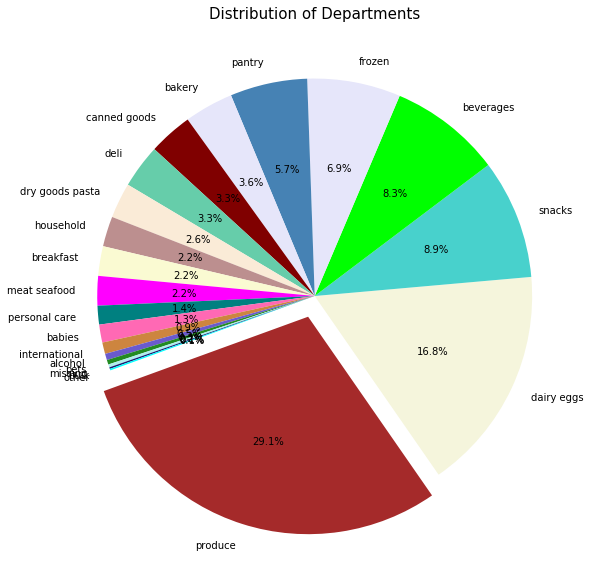

produce            137575
dairy eggs          79205
snacks              42027
beverages           39349
frozen              32816
pantry              27130
bakery              17229
canned goods        15448
deli                15370
dry goods pasta     12446
household           10586
breakfast           10414
meat seafood        10350
personal care        6580
babies               6314
international        4029
alcohol              2219
pets                 1616
missing              1057
bulk                  555
other                 535
Name: department, dtype: int64

In [47]:
# Department wise distribution plot
plt.figure(figsize=(10,10))
temp_series = orders['department'].value_counts()

labels = (np.array(temp_series.index))

sizes = (np.array((temp_series / temp_series.sum())*100))
explode = (0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 21)

plt.pie(sizes, labels=labels, explode=explode,
        autopct='%1.1f%%', startangle=200, colors=colors)
plt.title("Distribution of Departments", fontsize=15)
plt.show()


temp_series

There are in total 21 Departments, among this "produce"(fruits and vegetables) department has the maximum number of products with 29.1% and "dairy eggs" (eggs and milk products) holds a second place in the list with 16.8%. whereas "missing", "other" and "bulk" departments are having less percentage.

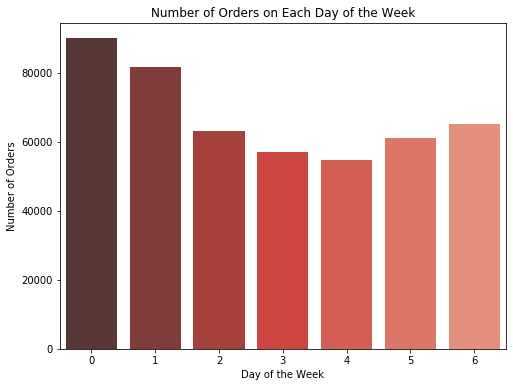

In [18]:
# let's do time seriers analysis on dataset
# days of orders in week
plt.figure(figsize=(8,6))

sns.countplot(x="order_dow", data=orders, palette=sns.color_palette("Reds_d",7))

plt.ylabel('Number of Orders')
plt.xlabel('Day of the Week')
plt.title('Number of Orders on Each Day of the Week')
plt.show()

There is a clear effect of day of the week. Most orders are on days 0 and 1. Unfortunately there is no information regarding which values represent which day, but one would assume that this is the weekend and in weekdays we can see there are less number of orders.


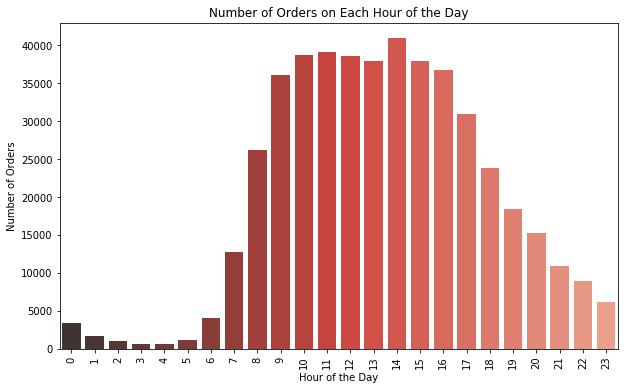

In [19]:
# hour of orders in a day 
plt.figure(figsize=(10,6))

sns.countplot(x="order_hour_of_day", data=orders, palette=sns.color_palette("Reds_d", 24))

plt.ylabel('Number of Orders')
plt.xlabel('Hour of the Day')
plt.xticks(rotation='vertical')
plt.title('Number of Orders on Each Hour of the Day')
plt.show()

People mostly order between 8 to 19 i.e. between 8 a.m to 7 p.m.

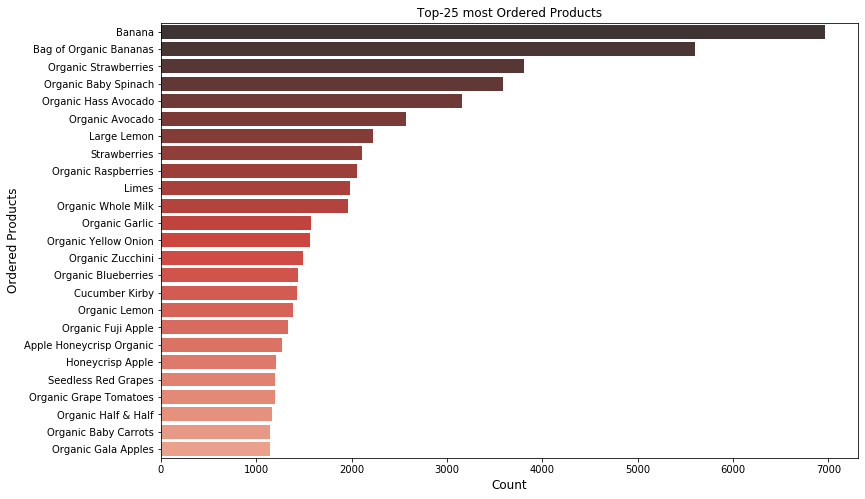

6    3420
5    3255
7    3192
4    3166
3    3008
Name: add_to_cart_order, dtype: int64

In [20]:
# lets check the Top-25 most Ordered Products
bestsellers = pd.DataFrame(orders["product_name"].value_counts()).reset_index()
bestsellers.columns = ["Product_name","count"]

f, ax = plt.subplots(figsize=(12.5, 8))

sns.barplot(x='count', y='Product_name', data=bestsellers[:25],palette="Reds_d")

plt.ylabel('Ordered Products', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.title("Top-25 most Ordered Products")
plt.show()

group.head()

As we saw earlier "produce" and "dairy egg" were leading departments, hence those department's items are in the top 25 most ordered. 

In [21]:
# lets check the bottom-10 least Ordered Products
leastseller=bestsellers
leastseller[-10:]

,Product_name,count
28691,Rich Dark Chocolate Nutrition Shake,1
28692,Slow Kettle Tuscan Style Chicken & White Bean ...,1
28693,Toaster Pops Strawberry,1
28694,Real Medleys Cherry Almond Pecan Multigrain Ce...,1
28695,Applewood Smoked Bacon Mashed,1
28696,Sesame Brittle Ice Cream,1
28697,Tension Head Ache Pain Reliever Caplets,1
28698,Mexican Cheddar Jack Shredded Cheese,1
28699,Lime Beer,1
28700,Peanut Butter Sandwich Breakfast Biscuits,1


By analyzing least sold items it will helps the retailer to add sale offers to these items to upscale the sale. 

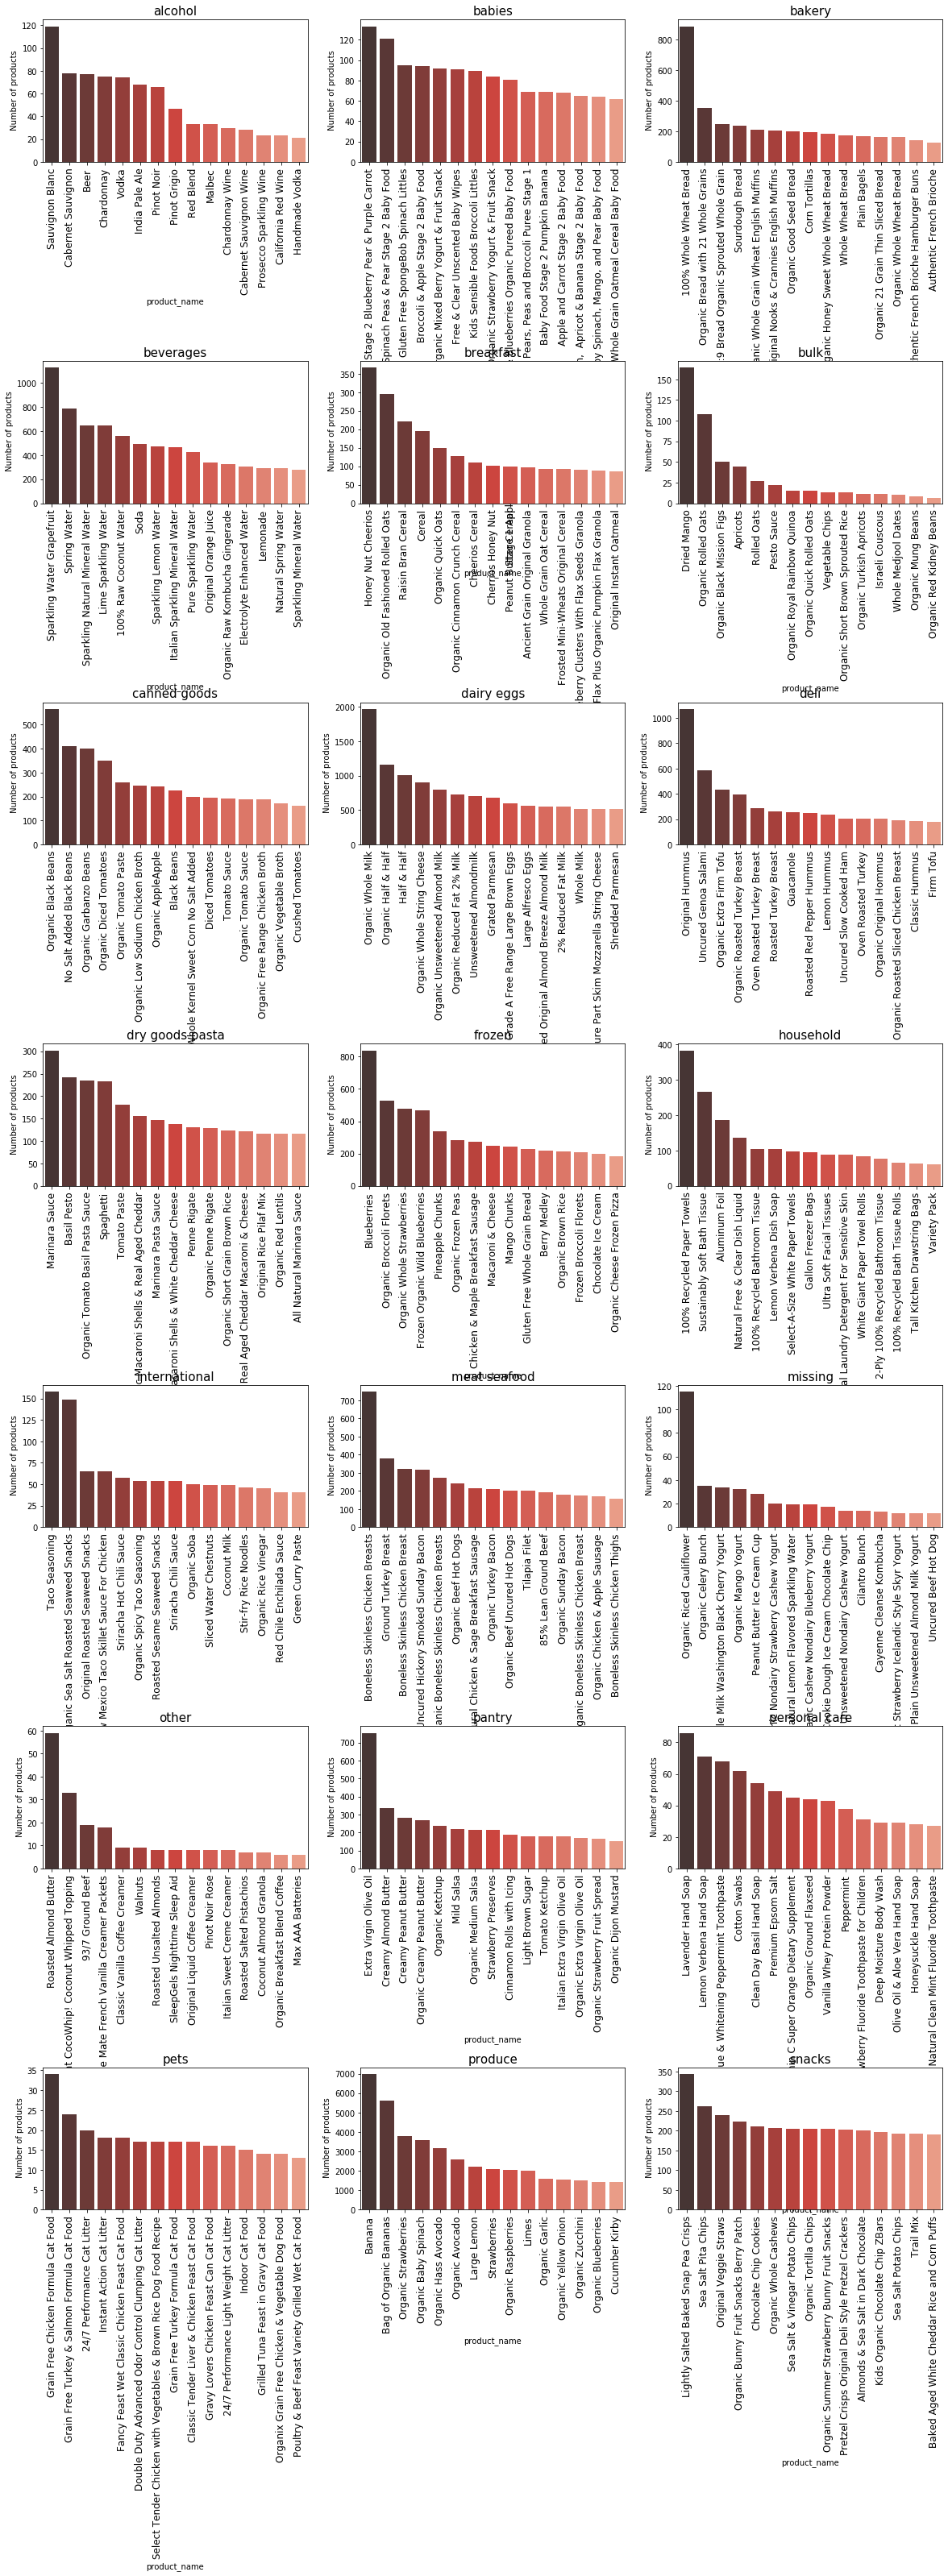

In [22]:
# most consumed items per department
grouped = orders.groupby(["department", "product_name"])["product_name"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,50), gridspec_kw =  dict(hspace=1.4))
for (departement_name, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.product_name[:15], group.Total_products , ax=ax,palette="Reds_d")
    ax.set(xlabel = "product_name", ylabel=" Number of products")
    g.set_xticklabels(labels = group.product_name,rotation=90, fontsize=12)
    ax.set_title(departement_name, fontsize=15)
    

Here we have a list of top 15 items from each department, this can be helpful for retailers to stock the items.

### Data Selection and Transformation:

As our objective is to work on association rule mining, we are more concerned about order_id and products. Hence we will be constructing a new dataframe in such a way that we will consider only the n-products (n stands for number of products in an order) and its frequency. From the Figure(a), we see that the data is huge and distribution is right-skewed, we will continue select only the data which lies around mean(10.07), as it will be difficult to apply apriori on huge data.

Considering whole data needs intensive computation and processing which requires a high configured system, on observing the figure(a) we came to know the data was skewed , so we thought that it will be the best practice to reduce a data using the box plot i.e we will be removing outlies such as the orders having large number of items (as these orders are less)


In [23]:
# Grouping the order items in a list
cart = orders.groupby('order_id')['product_name'].apply(list).reset_index(name='items')
cart["items_counts"] = [len(items) for items in cart["items"]]
# we are not considering a cart with only 1 item,
cart=cart[cart["items_counts"]>=2]
cart.head()

,order_id,items,items_counts
0,2,"[Organic Egg Whites, Michigan Organic Kale, Ga...",9
1,3,[Total 2% with Strawberry Lowfat Greek Straine...,8
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...",13
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan,...",26
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D...",3


Text(0.5, 1.0, 'Boxplot')

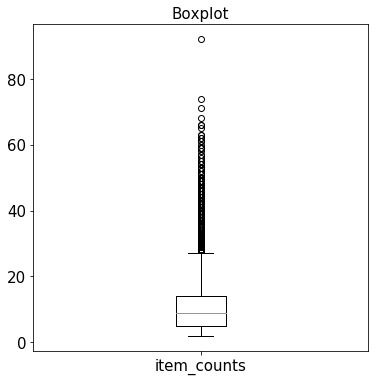

In [24]:
# boxplot
fig = plt.figure(figsize = (6, 6))
plt.boxplot(cart["items_counts"], labels= ["item_counts"])
plt.tick_params(labelsize = 15)
plt.title("Boxplot", fontsize = 15)


In [25]:
Q1 = cart["items_counts"].quantile(0.25)
Q3 = cart["items_counts"].quantile(0.75)
print("median:", np.median(cart["items_counts"]))
print("1st quartile:",Q1, "3rd quartile:",Q3)
IQR = Q3 - Q1
print("IQR:",IQR)
outliers=(cart["items_counts"] < (Q1 - 1.5 * IQR)) | (cart["items_counts"] > (Q3 + 1.5 * IQR))
print("minimum score:", min(cart["items_counts"]))
print("maximum score:", (Q3 + 1.5 * IQR))

# capturing dataset excluding outliers
cart=cart[~outliers]

median: 9.0
1st quartile: 5.0 3rd quartile: 14.0
IQR: 9.0
minimum score: 2
maximum score: 27.5


A box plot is a way of displaying the distribution of data based on five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). Even it can tell us about the outlier and what their values are. It can also tell us about whether it is symmetrical or not, from boxplot we can see how tightly our data is grouped.

Box plots divide the data into sections that each contain approximately 25% of the data in that set. Below are the important points while plotting boxplot.
1) Minimum Score: The lowest score, excluding outliers (shown at the end of the left whisker).

2) Lower Quartile(Q1): Twenty-five percent of scores fall below the lower quartile value (also known as the first quartile).

3) Median(Q2): The median marks the mid-point of the data and is shown by the line that divides the box into two parts (sometimes known as the second quartile). Half the scores are greater than or equal to this value and half are less.

4) Upper Quartile(Q3): Seventy-five percent of the scores fall below the upper quartile value (also known as the third quartile). Thus, 25% of data are above this value.

5) Maximum Score: The highest score, excluding outliers (shown at the end of the right whisker).

6) Whiskers: The upper and lower whiskers represent scores outside the middle 50% (i.e. the lower 25% of scores and the upper 25% of scores), The smallest value and largest value are found at the end of the ‘whiskers’ and are useful for providing a visual indicator regarding the spread of scores (e.g. the range)

7) The Interquartile Range (or IQR): This is the box plot showing the middle 50% of scores (i.e., the range between the 25th and 75th percentile), The interquartile range (IQR) is the box plot showing the middle 50% of scores and can be calculated by subtracting the lower quartile from the upper quartile (e.g. Q3−Q1).

8) Outlier: An outlier is an observation that is numerically distant from the rest of the data. When reviewing a box plot, an outlier is defined as a data point that is located outside the whiskers of the box plot. For example, outside 1.5 times the interquartile range above the upper quartile and below the lower quartile (Q1 - 1.5 * IQR or Q3 + 1.5 * IQR).


In [26]:
cart.head()

,order_id,items,items_counts
0,2,"[Organic Egg Whites, Michigan Organic Kale, Ga...",9
1,3,[Total 2% with Strawberry Lowfat Greek Straine...,8
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...",13
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan,...",26
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D...",3


#### Data Visualization on transformed data:

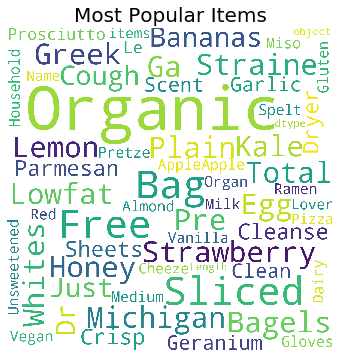

In [27]:
# wordcloud plot
plt.rcParams['figure.figsize'] = (15, 6)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(cart["items"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

In wordcloud plot "Organic" is a most used word in the entire dataset of products, which clearly implies that people/customers prefer more organic products. 

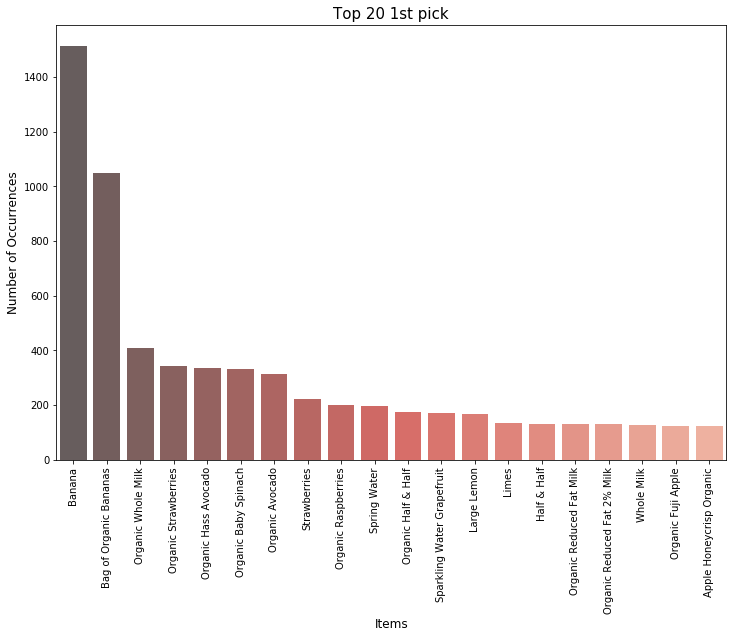

In [28]:
# lets check which are the most 1st pick items of the customers

from collections import Counter
count = Counter()
for i in cart["items"]:
    count[i[0]] +=1
l=count.most_common(20)  
color = sns.color_palette()
# plot the barplot
plt.figure(figsize=(12,8))
sns.barplot([i[0] for i in l], [i[1] for i in l], alpha=0.8, palette="Reds_d")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Items', fontsize=12)
plt.title('Top 20 1st pick', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


Customers prefers "Banana" as a first pick in their cart.

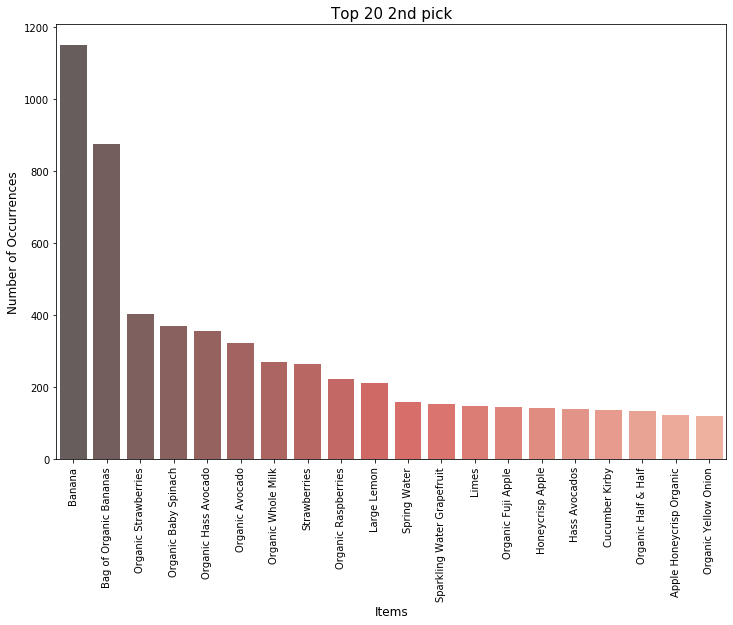

In [29]:
# similarly lets check most 2nd pick

from collections import Counter
count = Counter()
for i in cart["items"]:
    count[i[1]] +=1
m=count.most_common(20)  
color = sns.color_palette()
plt.figure(figsize=(12,8))
sns.barplot([i[0] for i in m], [i[1] for i in m], alpha=0.8, palette="Reds_d")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Items', fontsize=12)
plt.title('Top 20 2nd pick', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Even in the 2nd pick we can see "banana" is most picked, this could be because as the most consumed item is "banana" in the whole dataset.

#### Transformation of data acording to apriori algorithm:

In [30]:
order_list=list(cart["items"])

transaction = TransactionEncoder()
transaction_array = transaction.fit(order_list).transform(order_list)
cart = pd.DataFrame(transaction_array, columns=transaction.columns_)

In [31]:
cart.head()

,#2 Coffee Filters,#2 Cone White Coffee Filters,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,...,with Crispy Almonds Cereal,with Dawn Action Pacs Fresh Scent Dishwasher Detergent Pacs,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Seasoned Roasted Potatoes Scrambled Eggs & Sausage,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Association Rule mining:

Concept of Apriori Algorithm:

Apriori is an algorithm used to identify frequent item sets (in our case, item pairs). It does so using a "bottom up" approach, first identifying individual items that satisfy a minimum occurence threshold. It then extends the item set, adding one item at a time and checking if the resulting item set still satisfies the specified threshold. The algorithm stops when there are no more items to add that meet the minimum occurrence requirement. 

A key concept in Apriori algorithm is the anti-monotonicity of the support measure. It assumes that	all subsets of a frequent itemset must be frequent. Similarly, for any infrequent itemset, all its supersets must be infrequent too.

##### steps:

Step 1: Create a frequency table of all the items that occur in all the transactions.

Step 2: We know that only those elements are significant for which the support is greater than or equal to the threshold support.

Step 3: The next step is to make all the possible pairs of the significant items keeping in mind that the order doesn’t matter, i.e., AB is same as BA.

Step 4: We will now count the occurrences of each pair in all the transactions.

Step 5: Again only those itemsets are significant which cross the support threshol.

Step 6: Now let’s say we would like to look for a set of three items that are purchased together. We will use the itemsets found in step 5 and create a set of 3 items.

In [32]:
frequent_itemsets = apriori(cart, min_support=0.003, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.004272,(0% Greek Strained Yogurt)
1,0.003227,(1% Low Fat Milk)
2,0.003854,(1% Lowfat Milk)
3,0.003785,(100 Calorie Per Bag Popcorn)
4,0.011447,(100% Raw Coconut Water)


In [33]:
counts = Counter()
for i in frequent_itemsets["itemsets"]:
    counts[len(i)] +=1
counts   

Counter({1: 482, 2: 206, 3: 2})

After creating a frequency table of all the items that occur in all the transactions with minimum suport of 0.003, here we have

one frequent itemset counts : 482\
two frequent itemset counts : 206\
three frequent itemset counts : 2

#### Creating and Displaying Rules:

In [34]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0)
print("Total number of rules:",rules.sort_values('lift', ascending=False).shape[0])
rules=rules.sort_values('lift', ascending=False).reset_index()
rules.head(10)


Total number of rules: 424


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,250,(Sparkling Water Grapefruit),(Lime Sparkling Water),0.023753,0.013838,0.004319,0.181818,13.138804,0.003990,1.205309
1,251,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.013838,0.023753,0.004319,0.312081,13.138804,0.003990,1.419130
2,214,(Bunched Cilantro),(Limes),0.013769,0.041167,0.003901,0.283305,6.881936,0.003334,1.337855
3,215,(Limes),(Bunched Cilantro),0.041167,0.013769,0.003901,0.094755,6.881936,0.003334,1.089463
4,235,(Limes),(Jalapeno Peppers),0.041167,0.011934,0.003227,0.078398,6.569128,0.002736,1.072118
5,234,(Jalapeno Peppers),(Limes),0.011934,0.041167,0.003227,0.270428,6.569128,0.002736,1.314241
6,344,(Organic Ginger Root),(Organic Garlic),0.015858,0.032552,0.003227,0.203514,6.251883,0.002711,1.214645
7,345,(Organic Garlic),(Organic Ginger Root),0.032552,0.015858,0.003227,0.099144,6.251883,0.002711,1.092452
8,257,(Limes),(Organic Cilantro),0.041167,0.019387,0.004737,0.115059,5.934713,0.003938,1.108111
9,256,(Organic Cilantro),(Limes),0.019387,0.041167,0.004737,0.244311,5.934713,0.003938,1.268821


Typically, a lift value of 1 indicates that the probability of occurrence of the antecedent and consequent together are independent of each other. Hence, the idea is to look for rules having a lift much greater than 1. So, let's see how much rules has lift greater than 1 and less than one:

In [35]:
print("Rules with lift value greater than 1:")
print(rules[rules["lift"]>1].sort_values('lift', ascending=False).shape[0])
rules[rules["lift"]>1].sort_values('lift', ascending=False).head(10)

Rules with lift value greater than 1:
410


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,250,(Sparkling Water Grapefruit),(Lime Sparkling Water),0.023753,0.013838,0.004319,0.181818,13.138804,0.003990,1.205309
1,251,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.013838,0.023753,0.004319,0.312081,13.138804,0.003990,1.419130
2,214,(Bunched Cilantro),(Limes),0.013769,0.041167,0.003901,0.283305,6.881936,0.003334,1.337855
3,215,(Limes),(Bunched Cilantro),0.041167,0.013769,0.003901,0.094755,6.881936,0.003334,1.089463
4,235,(Limes),(Jalapeno Peppers),0.041167,0.011934,0.003227,0.078398,6.569128,0.002736,1.072118
5,234,(Jalapeno Peppers),(Limes),0.011934,0.041167,0.003227,0.270428,6.569128,0.002736,1.314241
6,344,(Organic Ginger Root),(Organic Garlic),0.015858,0.032552,0.003227,0.203514,6.251883,0.002711,1.214645
7,345,(Organic Garlic),(Organic Ginger Root),0.032552,0.015858,0.003227,0.099144,6.251883,0.002711,1.092452
8,257,(Limes),(Organic Cilantro),0.041167,0.019387,0.004737,0.115059,5.934713,0.003938,1.108111
9,256,(Organic Cilantro),(Limes),0.019387,0.041167,0.004737,0.244311,5.934713,0.003938,1.268821


In [36]:
print("Rules with lift value greater than 1:")
print(rules[rules["lift"]<1].sort_values('lift', ascending=False).shape[0])
rules[rules["lift"]<1].sort_values('lift', ascending=False).head(10)


Rules with lift value greater than 1:
14


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
410,102,(Bag of Organic Bananas),(Strawberries),0.119552,0.044673,0.005317,0.044475,0.995571,-0.000024,0.999793
411,103,(Strawberries),(Bag of Organic Bananas),0.044673,0.119552,0.005317,0.119023,0.995571,-0.000024,0.999399
412,163,(Banana),(Organic Half & Half),0.150921,0.024588,0.003645,0.024154,0.982325,-0.000066,0.999555
413,162,(Organic Half & Half),(Banana),0.024588,0.150921,0.003645,0.148253,0.982325,-0.000066,0.996868
414,31,(Organic Avocado),(Bag of Organic Bananas),0.054703,0.119552,0.006339,0.115874,0.969235,-0.000201,0.995840
415,30,(Bag of Organic Bananas),(Organic Avocado),0.119552,0.054703,0.006339,0.053020,0.969235,-0.000201,0.998223
416,189,(Banana),(Organic Yellow Onion),0.150921,0.032436,0.004597,0.030462,0.939118,-0.000298,0.997963
417,188,(Organic Yellow Onion),(Banana),0.032436,0.150921,0.004597,0.141732,0.939118,-0.000298,0.989294
418,24,(Bag of Organic Bananas),(Large Lemon),0.119552,0.046785,0.005108,0.042727,0.913250,-0.000485,0.995760
419,25,(Large Lemon),(Bag of Organic Bananas),0.046785,0.119552,0.005108,0.109181,0.913250,-0.000485,0.988358


from the above list we can see some rules are having a lift values almost equal to 1 i.e. (index 102,103,163 and 162) so they are independent to each other(i.e. customers less likly to buy these items together).

In [37]:
rules[rules["support"]>0].sort_values('support', ascending=False)

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
132,67,(Organic Hass Avocado),(Bag of Organic Bananas),0.066103,0.119552,0.018157,0.274675,2.297530,0.010254,1.213867
133,66,(Bag of Organic Bananas),(Organic Hass Avocado),0.119552,0.066103,0.018157,0.151874,2.297530,0.010254,1.101130
329,181,(Banana),(Organic Strawberries),0.150921,0.079431,0.017507,0.116000,1.460393,0.005519,1.041368
328,180,(Organic Strawberries),(Banana),0.079431,0.150921,0.017507,0.220403,1.460393,0.005519,1.089127
234,85,(Organic Strawberries),(Bag of Organic Bananas),0.079431,0.119552,0.017414,0.219234,1.833792,0.007918,1.127672
...,...,...,...,...,...,...,...,...,...,...
390,175,(Banana),(Organic Red Bell Pepper),0.150921,0.017507,0.003042,0.020154,1.151202,0.000399,1.002702
389,194,(Raspberries),(Banana),0.017344,0.150921,0.003018,0.174029,1.153119,0.000401,1.027978
388,195,(Banana),(Raspberries),0.150921,0.017344,0.003018,0.020000,1.153119,0.000401,1.002710
137,266,(Organic Yellow Onion),(Limes),0.032436,0.041167,0.003018,0.093057,2.260492,0.001683,1.057214


Here, confidence value of (Organic Half & Half) -->(Banana) is 0.148 which is quite good for our dataset(as we have huge number of orders) but the lift for the same is 0.98 which is close to 1 they are indipendent. so, both the metrics are having  contradicting result.

picking up the interesting rules considering both confidence and lift

In [38]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0)
rules.sort_values('confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
414,"(Organic Hass Avocado, Organic Raspberries)",(Bag of Organic Bananas),0.007476,0.119552,0.003274,0.437888,3.662732,0.002380,1.566321
107,(Bartlett Pears),(Banana),0.011284,0.150921,0.004156,0.368313,2.440440,0.002453,1.344145
127,(Honeycrisp Apple),(Banana),0.024890,0.150921,0.008800,0.353545,2.342588,0.005043,1.313439
150,(Organic Fuji Apple),(Banana),0.028489,0.150921,0.009914,0.348003,2.305870,0.005615,1.302276
179,(Organic Reduced Fat Milk),(Banana),0.010982,0.150921,0.003599,0.327696,2.171311,0.001941,1.262939


In [39]:
rules.sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
250,(Sparkling Water Grapefruit),(Lime Sparkling Water),0.023753,0.013838,0.004319,0.181818,13.138804,0.003990,1.205309
251,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.013838,0.023753,0.004319,0.312081,13.138804,0.003990,1.419130
214,(Bunched Cilantro),(Limes),0.013769,0.041167,0.003901,0.283305,6.881936,0.003334,1.337855
215,(Limes),(Bunched Cilantro),0.041167,0.013769,0.003901,0.094755,6.881936,0.003334,1.089463
235,(Limes),(Jalapeno Peppers),0.041167,0.011934,0.003227,0.078398,6.569128,0.002736,1.072118


case 1: (Organic Raspberries, Organic Hass Avocado)-->(Bag of Organic Bananas)\
This rule has high confidence value(0.43) as "banana" is in most of the orders because it’s a major consumed item in our dataset due to which we have to consider lift value but, lift value is comparably low (3.66) as it is also considering frequency of Banana while calculating (diving it by probability of Banana in the orders).

case 2:(Lime Sparkling Water)-->(Sparkling Water Grapefruit)\
This rule has good confidence value(0.31) even the highest lift value (as this rule does not have banana)

Both the values of these above rules are high so, we can conclude that these are the interesting rules and are more likely to bought together.


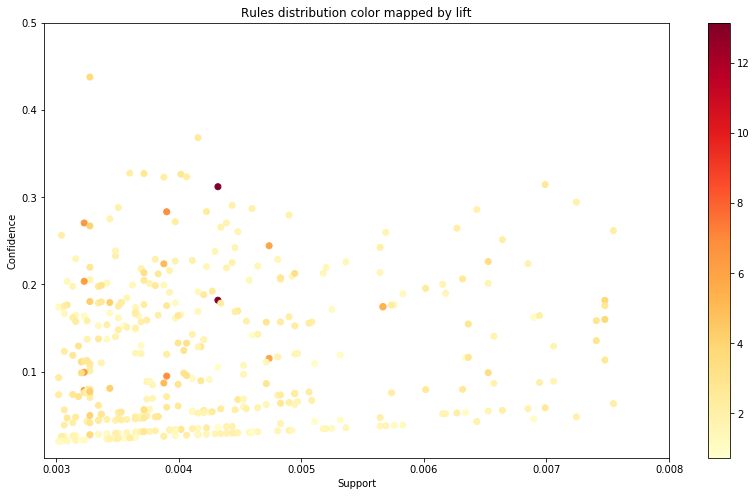

In [40]:
# Visualizing the rules distribution, color mapped by Lift.
plt.figure(figsize=(14, 8))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=2, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.xlim([0.0029, 0.008])
plt.ylim([0.001, 0.5])
plt.colorbar()

from the plot we can say that majority of data-points (rules) lies in range of support: 0.003 to 0.009 and confidence : 0.001 to 0.5

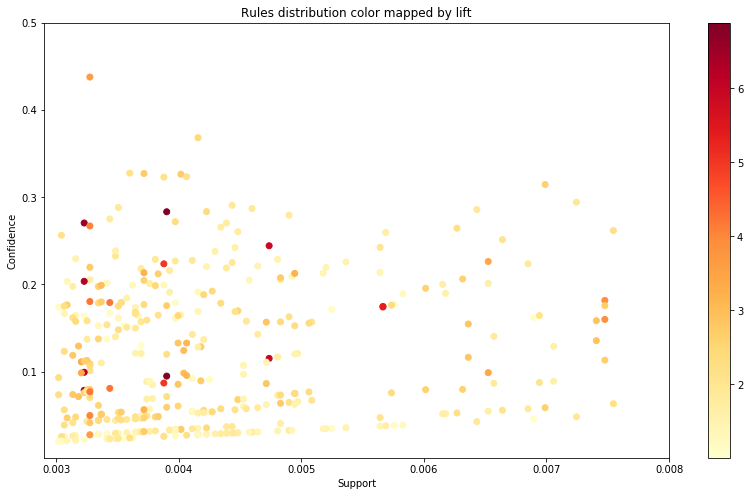

In [41]:
# Visualizing the rules distribution color mapped by Lift
rules_plot=rules[(rules["lift"]>1) & (rules["lift"]<9)]
plt.figure(figsize=(14, 8))
plt.scatter(rules_plot['support'], rules_plot['confidence'], c=rules_plot['lift'], alpha=2, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.xlim([0.0029, 0.008])
plt.ylim([0.001, 0.5])
plt.colorbar()

here we plotted a graph for a smaller lift range(1 to 9). we can see there are some rules(data-points) having good lift value(greater than 3) in spite of having lower support and confidence value by this we can summarize that though values are low but they are strongly dependent to each other.

### Recomendation:

We went further and created a Recommending System; it will recommend top 5 items which are similar to the selected item/product.
for Example: if a customer has added one/two item in to his/ her cart our Recommendation System Recommends a set of 5 related items(based on lift value).

For example, a customer who buys only one item i.e. "Limes", our recommendation system recommends 'Bunched Cilantro' ,'Jalapeno Peppers', 'Organic Cilantro', 'Large Lemon', 'Organic Garlic' and they look most-relatable! If the customer also thinks they are related to each other(like human-computer cooperation), he will go ahead and add them to cart. In this way, its profitable to the retailer where the customer who wanted to buy one item ends up buying more than one. 

One more fact  we observe is there is recommendation of 'Organic Cilantro' along with 'Bunched Cilantro', so he have many options to go with.


In [42]:
# Recommendation System
def recommendation(product):
    recommend_list=[]
    for index,items in enumerate(rules["antecedents"]):
        if len(product)>1:
            if product == items:
                if rules["lift"][index]>1:
                    recommend_list.append((rules["consequents"][index],rules["lift"][index]))
            for i in product:
                if i in items:
                    if rules["lift"][index]>1:
                        recommend_list.append((rules["consequents"][index],rules["lift"][index]))
        if (len(product)==1 and product == items):
            if rules["lift"][index]>1:
                recommend_list.append((rules["consequents"][index],rules["lift"][index]))
            
    return sorted(recommend_list,key=lambda x:x[1],reverse=True)


In [43]:
print("People who bought these items, also bought.\n")
recommendation({"Limes"})[:5]

People who bought these items, also bought.



[(frozenset({'Bunched Cilantro'}), 6.881936181565528),
 (frozenset({'Jalapeno Peppers'}), 6.569128145704811),
 (frozenset({'Organic Cilantro'}), 5.934713314487776),
 (frozenset({'Large Lemon'}), 3.881833233266015),
 (frozenset({'Organic Garlic'}), 3.0147915354183414)]

In [ ]:
print("People who bought these items, also bought.\n")
recommendation({"Organic Raspberries","Bag of Organic Bananas"})[:5]


### Future Scope:

As we have observed from unique product names, there are varieties in each unique product. For example: Banana, its variants are - Bananas, Organic bananas, Green Bananas, Bag of organic bananas, Organic Just bananas, baby bananas, Red bananas etc. So applying Natural Language processing on these product names would be helpful to consider all these under generic name called "Bananas". We can also add an option for buyer to select from available different types of bananas under the main category "Banana". By doing this, recommendation system considers all these types as a single type and make the recomender more efficient.\
Similarly, we have different products made out of bananas example: smoothie, juice, Yogurt and banana flavored eatables. NLP will help us in gathering all of them together and display the same results to buyer saying "You might like these banana flavored eatables!". This is a way to enhance customer buying experience.

If the customer has a monotonous pattern of buying the items he/she might get a same kind of recommendation itemset so, to change his/her pattern retailer can give a free item so that that recommendation pattern change based on the newly added product and also introduce customers to items they never would have tried before or even imagined existed!

### Conclusion:


As we have seen, the generation of rules is quite a simple process, but very computationally expensive, since it grows exponentially with the increase of set of items.

Overall, we seek the proper balance between support and confidence leading to a reasonable number of strong rules.but we cant only consider these metrics because many time there will be a conctradicting rules where both the metrics values will be high, in thouse time we need to consider lift values to select strong rules.

On observing, we saw that as the transaction data increase the suport value gets diluted, its same with the confidence value as well hence the maximum value of suport is 0.018 and confidenc is 0.43


Our Recommending System helps both customer and retailer, for customers it enhance the shopping experience by recommending items they never would have tried before or even imagined existed according to association rule algorithm, in turn it helps the retailer to increase their sale as the customer who intended to buy one item ends up buying more items. 
